In [14]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
import scipy.stats as stats
import sklearn.linear_model as lm
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.linear_model as lm
from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import  metrics
import ast
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, Reshape, AveragePooling1D, AveragePooling2D, MaxPool1D, MaxPool2D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow import keras    
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [35]:
df = pd.read_csv('games.csv', index_col=0)
df.head()

,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


In [36]:
df['Number of Reviews'].equals(df['Times Listed'])

True

In [37]:
print(df.duplicated().sum())
df = df.drop_duplicates()

382


In [38]:
df = df.drop(['Title', 'Summary', 'Reviews', 'Release Date', 'Team', 'Number of Reviews'], axis=1)
df

,Rating,Times Listed,Genres,Plays,Playing,Backlogs,Wishlist
0,4.5,3.9K,"['Adventure', 'RPG']",17K,3.8K,4.6K,4.8K
1,4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",21K,3.2K,6.3K,3.6K
2,4.4,4.3K,"['Adventure', 'RPG']",30K,2.5K,5K,2.6K
3,4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28K,679,4.9K,1.8K
4,4.4,3K,"['Adventure', 'Indie', 'Platform']",21K,2.4K,8.3K,2.3K
...,...,...,...,...,...,...,...
1507,3.2,94,"['Adventure', 'Point-and-Click']",763,5,223,67
1508,2.9,264,"['Arcade', 'Racing']",1.5K,49,413,107
1509,3.7,210,"['Brawler', 'RPG']",1.1K,45,487,206
1510,4.1,165,"['Adventure', 'RPG', 'Strategy', 'Tactical', '...",269,79,388,602


In [39]:
df['Genres'] = df['Genres'].apply(ast.literal_eval)

def NumTransform(x):
    scale = 1 
    if x[-1] == 'K':
        x = x[:-1]
        scale = 1000
    x = float(x)
    return x * scale

df['Plays'] = df['Plays'].apply(NumTransform)
df['Playing'] = df['Playing'].apply(NumTransform)
df['Backlogs'] = df['Backlogs'].apply(NumTransform)
df['Wishlist'] = df['Wishlist'].apply(NumTransform)
df['Times Listed'] = df['Times Listed'].apply(NumTransform)

df.head()

,Rating,Times Listed,Genres,Plays,Playing,Backlogs,Wishlist
0,4.5,3900.0,"[Adventure, RPG]",17000.0,3800.0,4600.0,4800.0
1,4.3,2900.0,"[Adventure, Brawler, Indie, RPG]",21000.0,3200.0,6300.0,3600.0
2,4.4,4300.0,"[Adventure, RPG]",30000.0,2500.0,5000.0,2600.0
3,4.2,3500.0,"[Adventure, Indie, RPG, Turn Based Strategy]",28000.0,679.0,4900.0,1800.0
4,4.4,3000.0,"[Adventure, Indie, Platform]",21000.0,2400.0,8300.0,2300.0


In [40]:
df.isna().sum()

Rating          13
Times Listed     0
Genres           0
Plays            0
Playing          0
Backlogs         0
Wishlist         0
dtype: int64

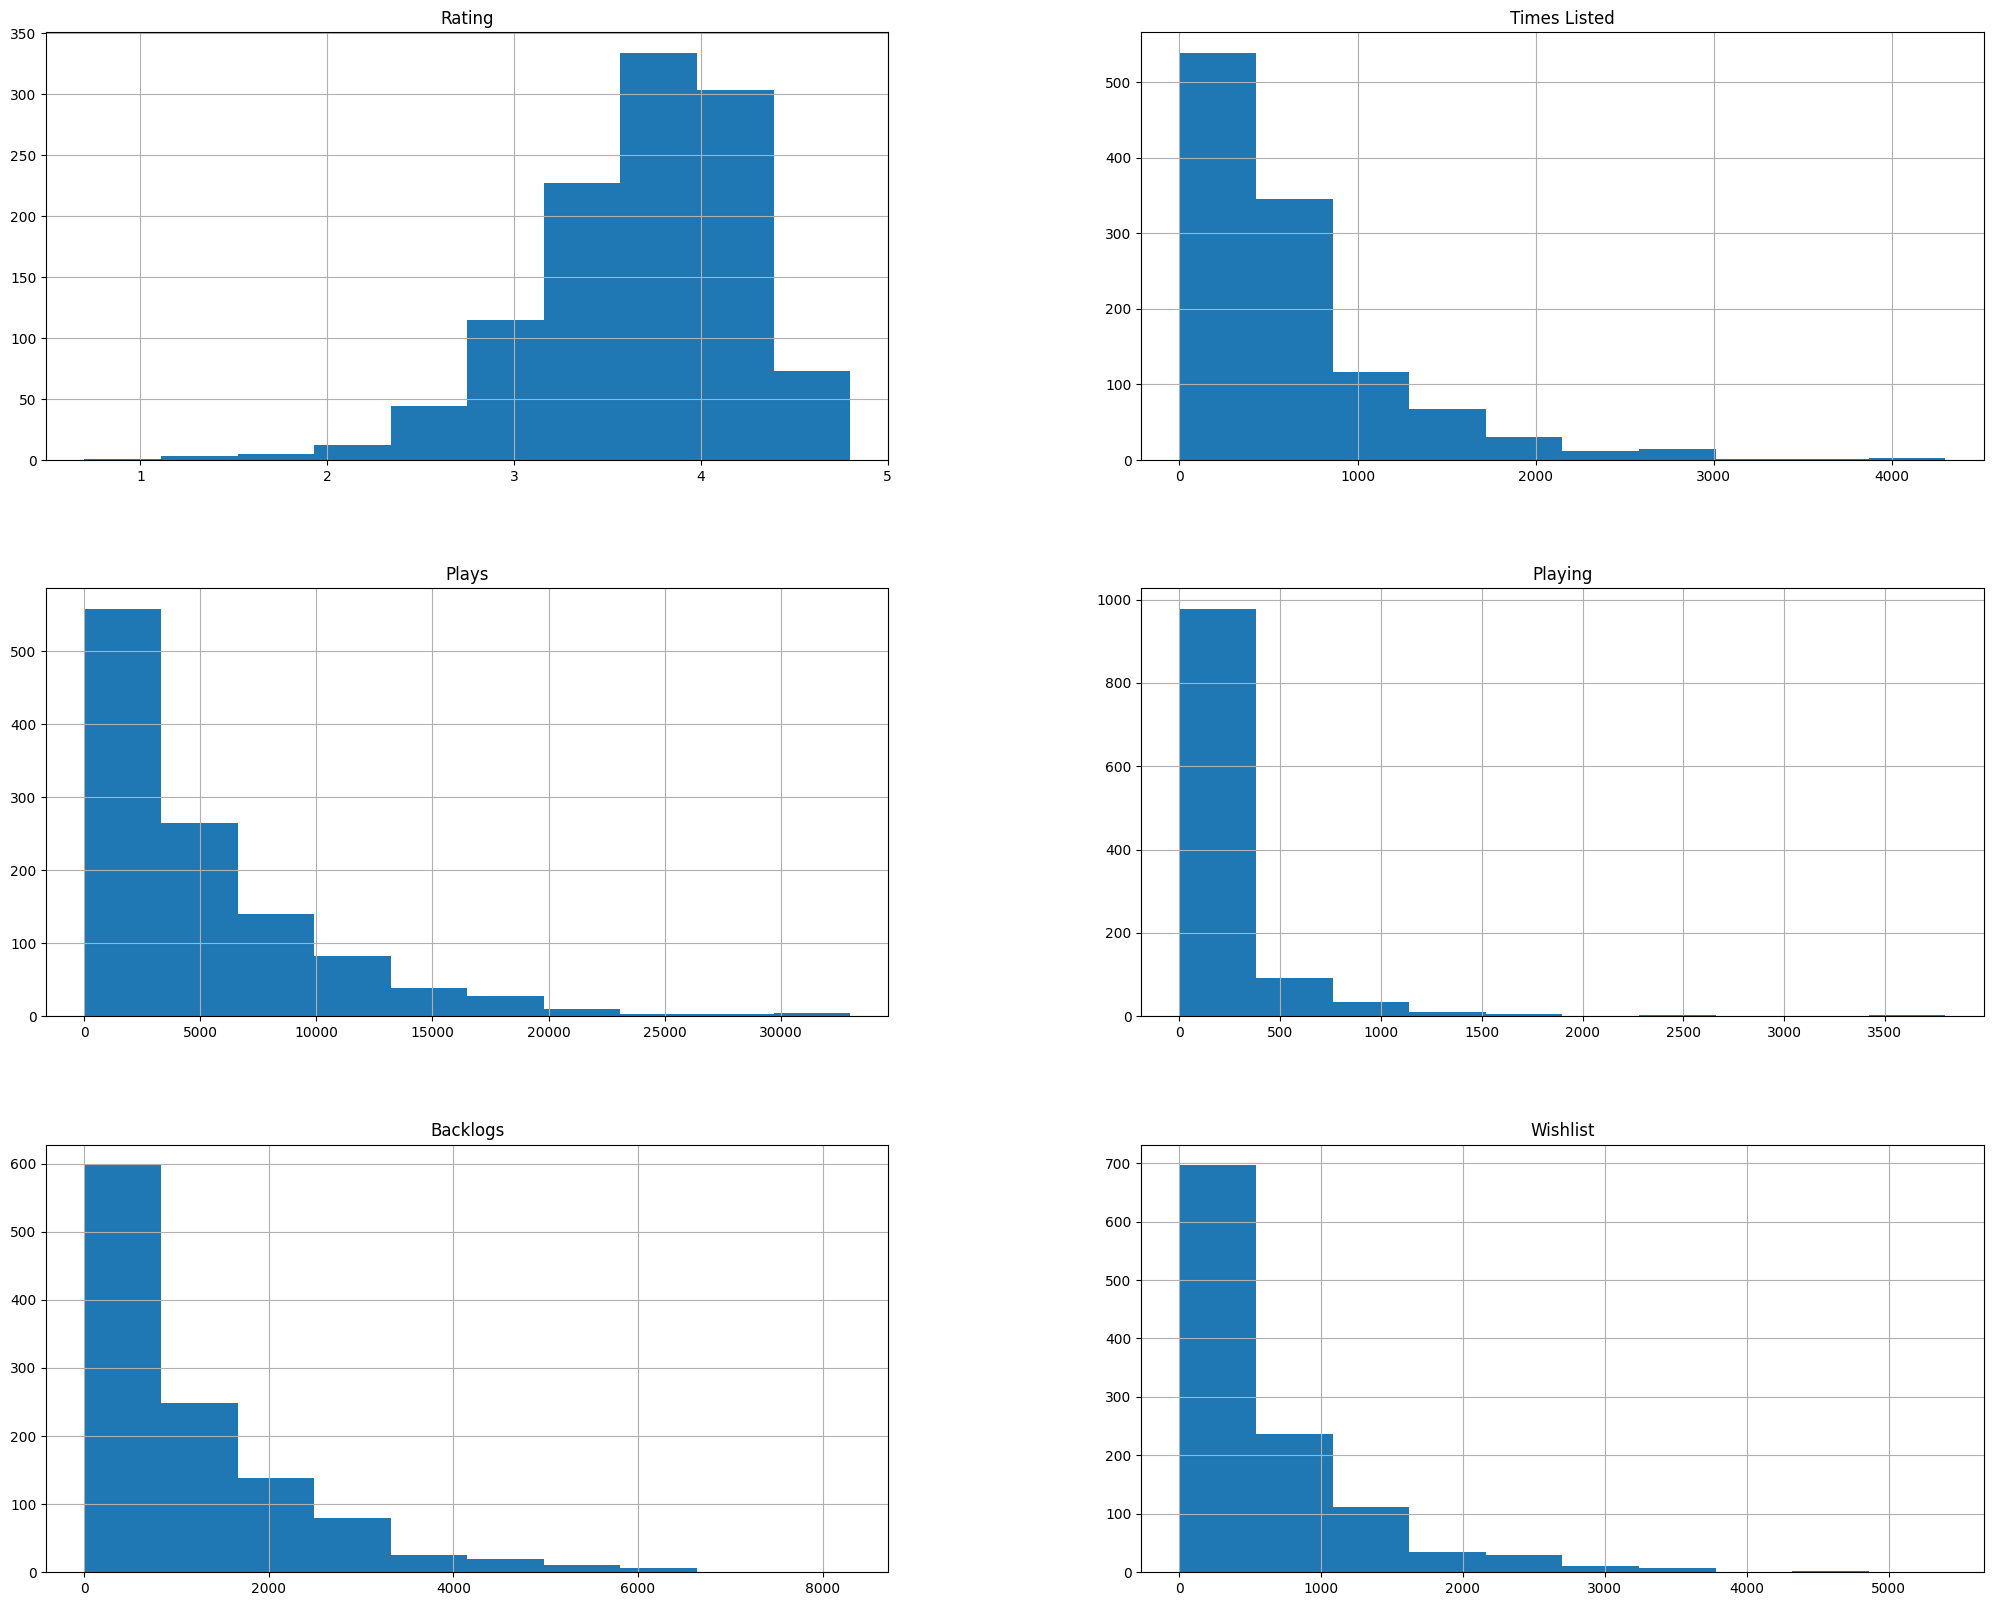

In [41]:
df.hist(figsize=(25, 20))
plt.show()

C:\Users\gapli\AppData\Local\Temp\ipykernel_17868\3359713059.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


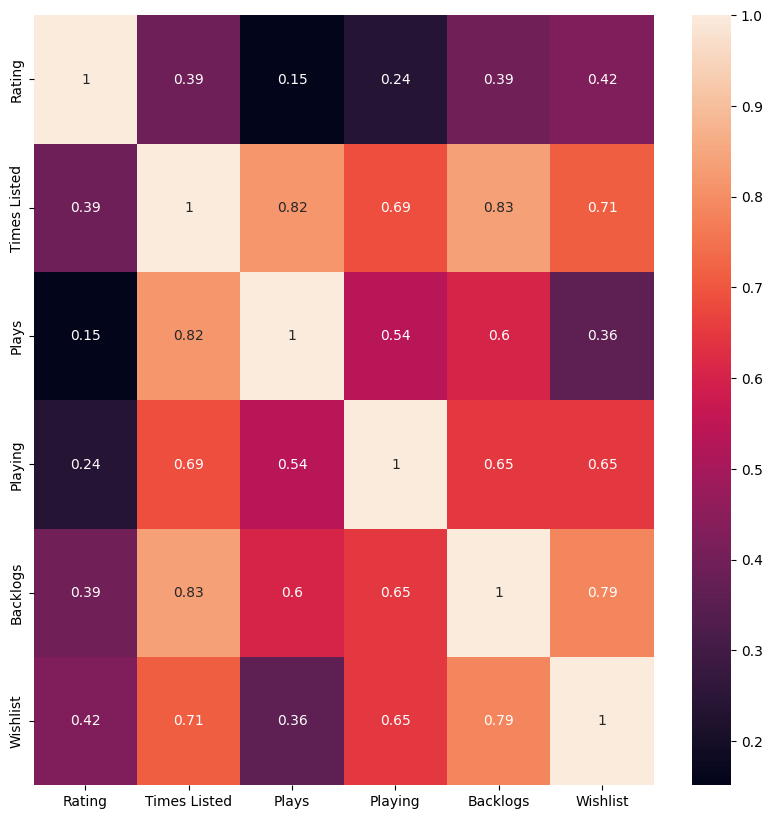

In [42]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

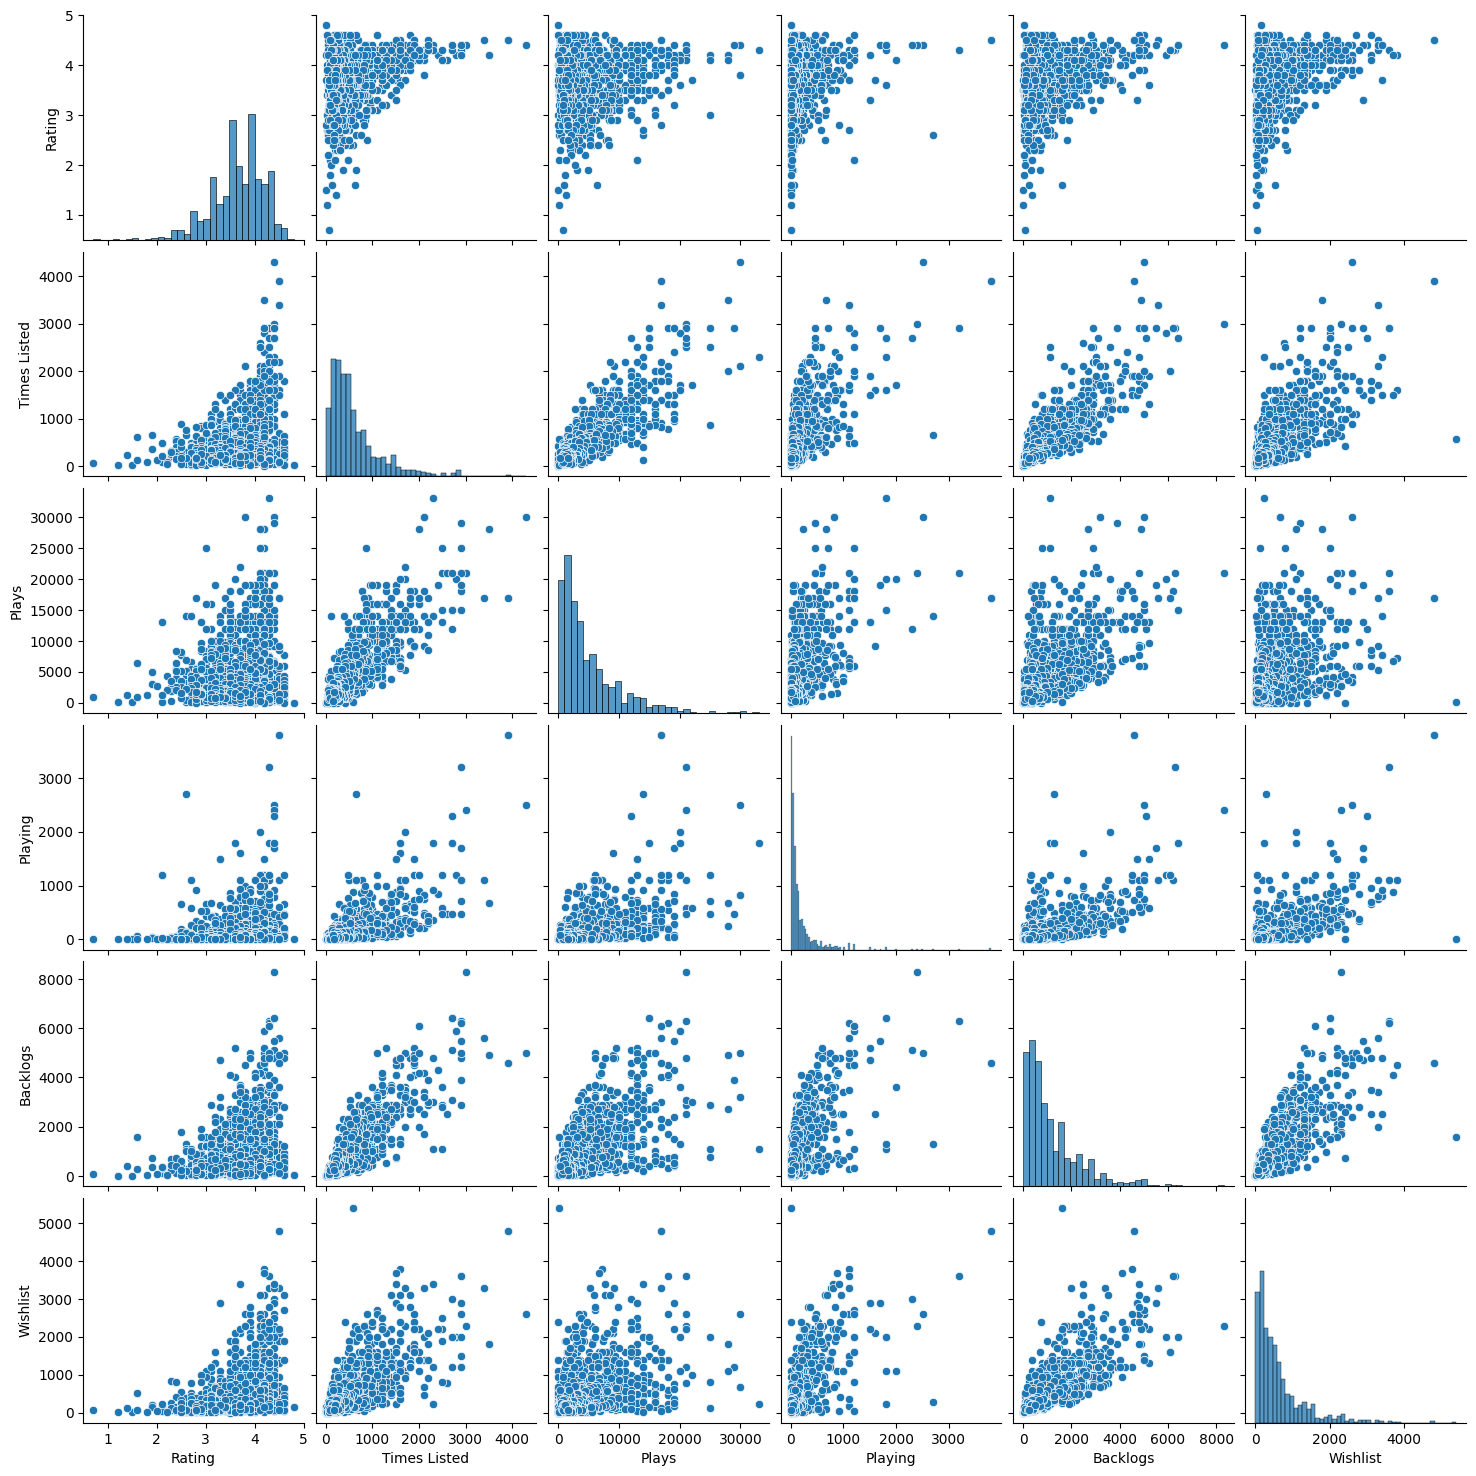

In [47]:
sns.pairplot(df)
plt.show()

In [43]:


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
      self.sparse_output = sparse_output
    def fit(self, X, y=None):
      self.enc = MultiLabelBinarizer(sparse_output=self.sparse_output)
      self.enc.fit(x[0] for x in X.values)
      return self
    def transform(self, X, y=None):
      return self.enc.transform(x[0] for x in X.values)


cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Genres"])),
        ("cat_encoder", CustomLabelBinarizer()),
    ])
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Rating", "Times Listed", "Plays", "Playing", "Backlogs"])),
        ("imputer", SimpleImputer(strategy="mean")),
    ])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
preprocess_pipeline.fit_transform(df)

array([[4.50e+00, 3.90e+03, 1.70e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.30e+00, 2.90e+03, 2.10e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.40e+00, 4.30e+03, 3.00e+04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       ...,
       [3.70e+00, 2.10e+02, 1.10e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [4.10e+00, 1.65e+02, 2.69e+02, ..., 1.00e+00, 1.00e+00, 0.00e+00],
       [2.80e+00, 1.84e+02, 1.70e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [44]:
X = df.drop(['Wishlist'], axis=1)
y = df['Wishlist']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.111111, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
kfold = model_selection.StratifiedKFold(n_splits=5, random_state=0, shuffle=True)


(904, 6) (904,)
(113, 6) (113,)


In [45]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.LinearRegression())])
param_grid={
    'pf__degree': [1, 2, 3, 4],
    'sc': [None, StandardScaler()]
            }
grid_linear = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_linear.fit(X_train_full, y_train_full)
print(grid_linear.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_linear.predict(X_train_full)) ))
print("R2: {}".format(metrics.r2_score(y_test, grid_linear.predict(X_test)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 1, 'sc': StandardScaler()}
R2: 0.7508729892193144
R2: 0.8052169395363284


c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(


In [332]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.Lasso(alpha=1.0))])
param_grid={
    'pf__degree': [1, 2, 3],
    'sc': [None, StandardScaler()],
    'regressor__alpha': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
            }
grid_lasso = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_lasso.fit(X_train_full, y_train_full)
print(grid_lasso.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_lasso.predict(X_train_full)) ))
print("R2: {}".format(metrics.r2_score(y_test, grid_lasso.predict(X_test)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 2, 'regressor__alpha': 10, 'sc': StandardScaler()}
R2: 0.8027665373527131
R2: 0.8191212244753248


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.919e+06, tolerance: 3.564e+04
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(


In [333]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.Ridge(alpha=1.0))])
param_grid={
    'pf__degree': [1, 2, 3],
    'sc': [None, StandardScaler()],
    'regressor__alpha': [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
            }
grid_ridge = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_ridge.fit(X_train_full, y_train_full)
print(grid_ridge.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_ridge.predict(X_train_full)) ))
print("R2: {}".format(metrics.r2_score(y_test, grid_ridge.predict(X_test)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 1, 'regressor__alpha': 100, 'sc': None}
R2: 0.7479195329088133
R2: 0.8112667553541842


c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(


In [334]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()), ('pf', PolynomialFeatures(degree=2)),
                       ('regressor', linear_model.ElasticNet(alpha=1.0))])
param_grid={
    'pf__degree': [1, 2, 3],
    'sc': [None, StandardScaler()],
    'regressor__alpha': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
            }
grid_elastic = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)


grid_elastic.fit(X_train_full, y_train_full)
print(grid_elastic.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_elastic.predict(X_train_full)) ))
print("R2: {}".format(metrics.r2_score(y_test, grid_elastic.predict(X_test)) ))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'pf__degree': 2, 'regressor__alpha': 10000, 'sc': None}
R2: 0.8007290964245473
R2: 0.8419457290233663


c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.016e+06, tolerance: 3.564e+04
  model = cd_fast.enet_coordinate_descent(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.917e+07, tolerance: 4.520e+04
  model = cd_fast.enet_coordinate_descent(


In [344]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()),
                       ('regressor', XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8))])
param_grid={
    'sc': [None, StandardScaler()],
    'regressor__max_depth': [3, 4, 5, 6, 7, 8],
    'regressor__subsample': [0.6, 0.7, 0.8],
    'regressor__eta': [0.1, 0.2, 0.3]
            }
grid_xgb = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_xgb.fit(X_train_full, y_train_full)
print(grid_xgb.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_xgb.predict(X_train_full)) ))
print("R2: {}".format(metrics.r2_score(y_test, grid_xgb.predict(X_test)) ))


c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'regressor__eta': 0.2, 'regressor__max_depth': 3, 'regressor__subsample': 0.8, 'sc': None}
R2: 0.9992926136105714
R2: 0.8579788955991251


In [337]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()),
                       ('regressor', SVR(kernel='rbf', C=0.01, gamma=0.1))])
param_grid={
    'sc': [None, StandardScaler()],
    'regressor__C': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.01, 0.1, 1, 10 ,100, 1000, 10000, 100000, 1000000],
    'regressor__gamma': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.01, 0.1, 1, 10 ,100, 1000, 10000, 100000, 1000000]
            }
grid_svr = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_svr.fit(X_train_full, y_train_full)
print(grid_svr.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_svr.predict(X_train_full))))
print("R2: {}".format(metrics.r2_score(y_test, grid_svr.predict(X_test))))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'regressor__C': 100000, 'regressor__gamma': 1e-08, 'sc': None}
R2: 0.8134651501663902
R2: 0.8469712864326219


In [339]:
estimator = Pipeline([('preprocess', preprocess_pipeline), ('sc', StandardScaler()),
                       ('regressor', RandomForestRegressor(n_estimators=200, max_depth=20, max_features=3, max_leaf_nodes=10))])
param_grid={
    'sc': [None, StandardScaler()],
    'regressor__max_depth': [50, 100, 150, 200, 250],
    'regressor__max_features': [5, 10, 15, 25, 35, 50, 100],
    'regressor__max_leaf_nodes': [30, 40, 50, 75, 100, 150]
            }
grid_rf = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=kfold,
                    refit=True)

grid_rf.fit(X_train_full, y_train_full)
print(grid_rf.best_params_)
print("R2: {}".format(metrics.r2_score(y_train_full, grid_rf.predict(X_train_full))))
print("R2: {}".format(metrics.r2_score(y_test, grid_rf.predict(X_test))))

c:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Pinball'] will be ignored
  warnings.warn(
c:\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es)

{'regressor__max_depth': 150, 'regressor__max_features': 15, 'regressor__max_leaf_nodes': 150, 'sc': StandardScaler()}
R2: 0.9604767167119233
R2: 0.8599873308666874


In [340]:
pipe = make_pipeline(preprocess_pipeline, StandardScaler(), PolynomialFeatures(1))

X_train2 = pipe.fit_transform(X_train)
X_Val_2 = pipe.transform(X_val)
X_test2 = pipe.transform(X_test)

In [341]:
ne = Sequential([
    Dense(3000, activation="elu"),
    Dropout(0.5),
    Dense(1000, activation="elu"),
    Dropout(0.5),
    Dense(1000, activation="elu"),
    Dropout(0.5),
    Dense(100, activation="elu"),
    Dropout(0.5),
    Dense(1)
])
early_stopping = EarlyStopping(
    patience=16,
    restore_best_weights=True,
)
ne.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(0.001))

ne.fit(X_train2, y_train, epochs=1000, validation_data=(X_Val_2, y_val), verbose=0, batch_size=32,
                    callbacks=[early_stopping])

print("R2: {}".format(metrics.r2_score(y_train, ne.predict(X_train2)) ))
print("R2: {}".format(metrics.r2_score(y_test, ne.predict(X_test2)) ))


29/29 [==============================] - 0s 7ms/step
R2: 0.8388501604372183
4/4 [==============================] - 0s 9ms/step
R2: 0.8480560757115612


In [342]:
ne_conv = Sequential([
    Dense(8000, activation="elu"),
    Reshape((20, 20, 20)),
    Conv2D(100, (5, 5), activation="elu"),
    AveragePooling2D(),
    Conv2D(100, (5, 5), activation="elu", strides=(2, 2)),
    AveragePooling2D(),
    Flatten(),
    Dense(1000, activation="elu"),
    Dropout(0.5),
    Dense(100, activation="elu"),
    Dropout(0.5),
    Dense(1)
])

early_stopping = EarlyStopping(
    patience=16,
    restore_best_weights=True,
)

ne_conv.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(0.001))

ne_conv.fit(X_train2, y_train, epochs=1000, validation_data=(X_Val_2, y_val), verbose=0, batch_size=8,
                    callbacks=[early_stopping])
print("R2: {}".format(metrics.r2_score(y_train, ne_conv.predict(X_train2)) ))
print("R2: {}".format(metrics.r2_score(y_test, ne_conv.predict(X_test2)) ))


29/29 [==============================] - 0s 14ms/step
R2: 0.8322190372657007
4/4 [==============================] - 0s 13ms/step
R2: 0.8294883109262804
